
# Multimodal Recommendation System

This notebook presents a hybrid recommendation engine that leverages both visual (image) and textual (title) features to recommend products.

---

## 1. Introduction to Libraries

We use a range of libraries across data loading, neural network modeling, evaluation, and visualization:

- **Data Handling**:
  - `pandas`: For handling CSVs and tabular data.
  - `pickle`: To load saved Python objects like precomputed embeddings.
  - `os`, `re`: For file paths and regex operations.

- **Image Processing**:
  - `PIL`: To open and manipulate images.
  - `torchvision.transforms`: For image preprocessing like resizing and tensor conversion.

- **Text Processing**:
  - `nltk`: For BLEU score evaluation of generated text.

- **Deep Learning** _(PyTorch Only)_:
  - `torch`, `torch.nn`: Core neural network modules.
  - `torch.utils.data`: Dataset & Dataloader abstractions.
  - `torch.nn.functional`: Functional interface like cosine similarity.

- **Evaluation & Visualization**:
  - `sklearn.metrics`: For accuracy score.
  - `matplotlib.pyplot`: To visualize images and training results.
  - `tqdm`: For progress bars.

> ℹ **Setup Note**: Run the following to install missing libraries (e.g., nltk):
```bash
pip install nltk
```


In [ ]:
import os
import re
import math
import pickle
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cosine_similarity


---

## 2. Model Design and Implementation

This section defines the multimodal recommendation model that fuses both image and text embeddings.

### Architecture Overview

- **Input**:
  - Image embeddings (from a CNN encoder)
  - Text embeddings (from a bag-of-words or transformer-based encoder)

- **Fusion Strategy**:
  - We concatenate both feature vectors to form a joint representation.

- **Output**:
  - A similarity score for top-N product recommendations.

Below, we walk through the model classes and helper functions, step by step.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Load and Explore Dataset

We now load the dataset containing product information. Each entry contains:
- `asin`: Unique product identifier
- `title`: Textual title of the product
- `image_name`: name for the product image

This data will be used to power the recommendation logic.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/final_dataset.csv')
df

### Divide into test, train and validation dataset

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Further split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
print(f"Number of filtered test images: {len(test_df)}")
print(f"Number of filtered train images: {len(train_df)}")
print(f"Number of filtered validation images: {len(val_df)}")

### Build Word Tokenizer

In [ ]:
class SimpleTokenizer:
    """
    A basic word-level tokenizer for converting text into token IDs.

    This tokenizer supports:
    - Vocabulary building from a list of text inputs
    - Encoding text into fixed-length token sequences with padding
    - Decoding token IDs back to text

    Special tokens:
    - <PAD>: Used for padding (ID 0)
    - <UNK>: Unknown token (ID 1)
    """

    def __init__(self):
        # Initialize vocab with special tokens
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.vocab_size = 2
        self.pad_token_id = 0

    def build_vocab(self, text_list):
        """
        Builds vocabulary from a list of input strings.

        Parameters:
            text_list (List[str]): List of sentences or phrases
        """
        for text in text_list:
            for word in text.lower().split():
                if word not in self.word2idx:
                    self.word2idx[word] = self.vocab_size
                    self.idx2word[self.vocab_size] = word
                    self.vocab_size += 1

    def encode(self, text, max_len):
        """
        Encodes a text string into a list of token IDs with padding.

        Parameters:
            text (str): Input sentence
            max_len (int): Desired fixed sequence length

        Returns:
            List[int]: Token ID sequence of length `max_len`
        """
        tokens = [self.word2idx.get(w, 1) for w in text.lower().split()]  # 1 = <UNK>
        tokens = tokens[:max_len] + [0] * (max_len - len(tokens))  # Pad with 0s
        return tokens

    def decode(self, token_ids):
        """
        Converts a list of token IDs back into a string.

        Parameters:
            token_ids (List[int]): Sequence of token IDs

        Returns:
            str: Decoded string with unknowns shown as "<UNK>"
        """
        return " ".join([self.idx2word.get(idx, "<UNK>") for idx in token_ids])

In [ ]:
# Instantiate the tokenizer
tokenizer = SimpleTokenizer()

# Build vocabulary from product titles
# - Converts each title to lowercase
# - Adds new words to the vocabulary with unique IDs
tokenizer.build_vocab(df['title'].tolist())

### Dataset & DataLoader for Prime Pantry Products

In [ ]:
class PantryDataset(Dataset):
    """
    Custom Dataset for loading Prime Pantry product images and titles.

    Each item consists of:
    - A transformed image tensor
    - A tokenized and padded title sequence

    Parameters:
        dataframe (pd.DataFrame): Dataset with 'image_name' and 'title' columns
        tokenizer (SimpleTokenizer): Tokenizer for encoding titles
        image_transform (callable): Image transformation pipeline
        max_len (int): Maximum token sequence length
    """
    def __init__(self, dataframe, tokenizer, image_transform, max_len):
        self.dataframe = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Get image path and title
        image_path = os.path.join(
            "/content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All",
            row['image_name']
        )
        caption = row['title']

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.image_transform(image)

        # Encode caption text to token sequence
        tokens = self.tokenizer.encode(caption, max_len=self.max_len)
        return image, torch.tensor(tokens)

In [ ]:
# --------------------------------------------------
# Custom Collate Function for Padding Captions
# --------------------------------------------------
def custom_collate(batch, pad_token_id):
    """
    Pads sequences to the same length within a batch.

    Parameters:
        batch: List of (image, caption_tensor) pairs
        pad_token_id: ID used for padding

    Returns:
        images (Tensor): Batch of image tensors
        captions (Tensor): Batch of padded token sequences
    """
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = torch.nn.utils.rnn.pad_sequence(
        captions, batch_first=True, padding_value=pad_token_id
    )
    return images, captions

In [ ]:
# --------------------------------------------------
# Image Transformation
# --------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Maximum token length per title
MAX_LEN = 64

In [ ]:
# --------------------------------------------------
# Prepare Train/Validation/Test Datasets
# --------------------------------------------------
train_dataset = PantryDataset(train_df, tokenizer, transform, max_len=MAX_LEN)
val_dataset   = PantryDataset(val_df, tokenizer, transform, max_len=MAX_LEN)
test_dataset  = PantryDataset(test_df, tokenizer, transform, max_len=MAX_LEN)

In [ ]:
# --------------------------------------------------
# DataLoaders
# --------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          collate_fn=lambda x: custom_collate(x, tokenizer.pad_token_id))
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False,
                          collate_fn=lambda x: custom_collate(x, tokenizer.pad_token_id))
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          collate_fn=lambda x: custom_collate(x, tokenizer.pad_token_id))

### Multimodal Embedder with Attention Mechanism
This module implements a simplified multi-head attention mechanism, which is key to capturing contextual information across multiple modes (text, image).

The text and image inputs are processed separately using respective encoders. These encoded inputs are converted into unified embeddings.

In [ ]:
# ---------- Basic Attention & Positional Encoding ----------
def scaled_dot_context(q, k, v, mask=None):
    """
      Computes scaled dot-product attention.

      Parameters:
          q (Tensor): Queries tensor of shape (B, H, T, Dk)
          k (Tensor): Keys tensor of shape (B, H, T, Dk)
          v (Tensor): Values tensor of shape (B, H, T, Dv)
          mask (Tensor, optional): Mask tensor to prevent attention to certain positions

      Returns:
          Tensor: Attention-weighted output
      """
    d_k = q.size(-1)  # scale factor based on key dimension
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) # scaled dot-product
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # mask out invalid positions
    attn = torch.softmax(scores, dim=-1)  # apply softmax to get attention weights
    return torch.matmul(attn, v) # weighted sum of values

class MultiContextualFocus(nn.Module):
      """
      Implements multi-head attention as a contextual focus module.

      Attributes:
          dim_model (int): Total dimension of the model
          num_heads (int): Number of parallel attention heads
      """
    def __init__(self, dim_model, num_heads):
        super().__init__()
        assert dim_model % num_heads == 0 # Model dimension must be divisible by number of heads
        self.num_heads = num_heads
        self.head_dim = dim_model // num_heads

        # Linear projections for queries, keys, and values
        self.to_q = nn.Linear(dim_model, dim_model)
        self.to_k = nn.Linear(dim_model, dim_model)
        self.to_v = nn.Linear(dim_model, dim_model)
        # Output projection layer
        self.merge = nn.Linear(dim_model, dim_model)

    def forward(self, q, k, v, mask=None):
        """
        Forward pass of the multi-head attention mechanism.

        Parameters:
            q, k, v (Tensor): Input embeddings (B, T, D)
            mask (Tensor, optional): Optional mask for attention weights

        Returns:
            Tensor: Contextualized representation after attention
        """
        B = q.size(0)
        # Linear projections + reshape for multi-head split
        q = self.to_q(q).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.to_k(k).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.to_v(v).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention across all heads
        context = scaled_dot_context(q, k, v, mask)
        # Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.head_dim)
        return self.merge(context)

## ContextProjectionBlock: Feedforward Layer in Transformer

The `ContextProjectionBlock` is a fundamental building block used in Transformer architectures to increase the model’s representation power. It applies a two-layer fully connected network with a ReLU activation between the layers.

### Why It’s Used:
This block allows the model to:
- Expand and project information into a higher-dimensional space.
- Introduce non-linearity, enabling complex pattern learning.
- Return to the original dimensionality to preserve sequence compatibility.

This is equivalent to the "Position-wise Feedforward Network" described in the original Transformer paper.

### Structure:
1. Linear Projection: `dim_model → dim_ff`
2. ReLU Activation
3. Linear Projection: `dim_ff → dim_model`

This structure is used in each Transformer block, both in encoders and decoders, to complement the attention mechanism.


In [ ]:
class ContextProjectionBlock(nn.Module):
    """
    Implements a simple Feedforward Projection Block used in Transformer architectures.

    This block applies two linear transformations with a ReLU activation in between:
    - Projects input from model dimension to a higher feedforward (FF) dimension
    - Applies non-linearity (ReLU)
    - Projects back to the original model dimension

    Parameters:
        dim_model (int): Dimensionality of input and output features
        dim_ff (int): Dimensionality of the intermediate feedforward layer
    """
    def __init__(self, dim_model, dim_ff):
        super().__init__()
        # First linear layer projects to a higher-dimensional space
        self.map1 = nn.Linear(dim_model, dim_ff)
        # Activation introduces non-linearity
        self.activate = nn.ReLU()
        # Second linear layer projects back to the model dimension
        self.map2 = nn.Linear(dim_ff, dim_model)

    def forward(self, x):
        """
        Forward pass through the feedforward block.

        Parameters:
            x (Tensor): Input tensor of shape (B, T, dim_model)

        Returns:
            Tensor: Output tensor of the same shape after projection and activation
        """
        return self.map2(self.activate(self.map1(x)))

## OrderAwarenessModule: Positional Encoding Layer

The `OrderAwarenessModule` injects **sequence order information** into the model’s input embeddings. This is crucial because self-attention mechanisms are permutation-invariant—they do not inherently encode order unless explicitly introduced.

### Why It’s Needed:
Transformers operate without recurrence or convolution. To understand the position of tokens in a sequence, they require **positional encodings**.

This module implements the **fixed sinusoidal positional encoding** introduced in *"Attention is All You Need"* (Vaswani et al., 2017). These encodings help the model:
- Distinguish the position of tokens
- Capture relative and absolute position information

### Strategy:
- Uses sine functions for even indices, cosine functions for odd indices
- Frequency of the signals varies exponentially across dimensions
- No trainable parameters; purely deterministic and generalizable to longer sequences

### Output:
Adds the precomputed positional encoding to the input embeddings:
Output = Input + PositionalEncoding


This ensures that the position of each token is embedded directly into the representation used by subsequent layers.



In [ ]:
class OrderAwarenessModule(nn.Module):
    """
    Implements positional encoding to inject order information into input sequences.

    This module follows the sinusoidal positional encoding strategy described in the
    "Attention is All You Need" paper (Vaswani et al., 2017). It uses fixed encodings
    based on sine and cosine functions of varying frequencies.

    Parameters:
        dim_model (int): Dimensionality of the model embeddings
        max_len (int): Maximum sequence length for which to compute encodings
    """
    def __init__(self, dim_model, max_len=5000):
        super().__init__()
        # Initialize positional encoding matrix
        pe = torch.zeros(max_len, dim_model)
        # Position indices (0, 1, 2, ..., max_len-1)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
         # Compute the frequency terms for the positional encoding
        term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))

        # Apply sine to even indices in the array; cosine to odd indices
        pe[:, 0::2] = torch.sin(pos * term)
        pe[:, 1::2] = torch.cos(pos * term)
        # Register buffer so it's saved with the model but not updated during training
        self.register_buffer('pe', pe.unsqueeze(0)) # shape: (1, max_len, dim_model)

    def forward(self, x):
        """
        Adds positional encoding to the input tensor.

        Parameters:
            x (Tensor): Input tensor of shape (B, T, dim_model)

        Returns:
            Tensor: Output tensor with positional encoding added
        """
        return x + self.pe[:, :x.size(1)]

## ContextualBlock: Transformer Encoder/Decoder Unit

The `ContextualBlock` implements a modular building block inspired by the Transformer architecture. It supports both standard self-attention (for encoders) and optional cross-attention (for decoders), making it suitable for multimodal or sequence-to-sequence tasks.

### Purpose

This block is designed to:
- Model dependencies within a sequence using self-attention
- Integrate external context (e.g., image or text features) using cross-attention when required
- Refine representations using a feedforward projection layer
- Normalize activations to stabilize training

### Key Components

- **Self-Attention (`self_attend`)**: Enables each token to attend to all others in the input sequence.
- **Cross-Attention (`cross_attend`)**: Allows the current sequence to attend to an external context (used in decoder layers).
- **Feedforward Block (`expand`)**: Two linear layers with ReLU activation to enrich representations.
- **Layer Normalization (`norm1`, `norm2`, `norm3`)**: Follows pre-normalization scheme for stable gradient flow.
- **Residual Connections**: Preserve input information and help with gradient propagation.

### Control via `cross` Flag

The `cross` parameter allows this block to be reused for both encoder and decoder roles:
- When `cross=False`: Behaves like a standard encoder block
- When `cross=True`: Enables cross-attention for decoder functionality

### Output

The block returns a transformed tensor of the same shape as the input:

Input: (B, T, dim_model)

Output: (B, T, dim_model)


This module forms the core of both the visual and text interpreters in the overall model architecture.

In [ ]:
class ContextualBlock(nn.Module):
    """
    Implements a transformer-style contextual block with optional cross-attention.

    This module follows the architecture of a Transformer encoder block, including:
    - Multi-head self-attention
    - Optional cross-attention for encoder-decoder interaction
    - Position-wise feedforward projection
    - Layer normalization at each stage (pre-norm)

    Parameters:
        dim_model (int): Dimensionality of input and output features
        num_heads (int): Number of attention heads
        dim_ff (int): Hidden dimension of the feedforward block
        cross (bool): Whether to enable cross-attention (e.g., for decoder blocks)
    """
    def __init__(self, dim_model, num_heads, dim_ff, cross=False):
        super().__init__()
        # Multi-head self-attention mechanism
        self.self_attend = MultiContextualFocus(dim_model, num_heads)
        # Optional cross-attention (e.g., used in decoder blocks)
        self.cross_attend = MultiContextualFocus(dim_model, num_heads) if cross else None

        # Feedforward projection block
        self.expand = ContextProjectionBlock(dim_model, dim_ff)

        # Layer normalization layers (pre-norm configuration)
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.norm3 = nn.LayerNorm(dim_model) if cross else None

        # Flag to control use of cross-attention
        self.cross = cross

    def forward(self, x, context=None, self_mask=None, cross_mask=None):
        """
        Forward pass through the contextual block.

        Parameters:
            x (Tensor): Input tensor of shape (B, T, dim_model)
            context (Tensor, optional): External context for cross-attention
            self_mask (Tensor, optional): Attention mask for self-attention
            cross_mask (Tensor, optional): Attention mask for cross-attention

        Returns:
            Tensor: Output tensor of shape (B, T, dim_model)
        """

        # Apply self-attention with residual connection and normalization
        x = self.norm1(x + self.self_attend(x, x, x, self_mask))

        # If cross-attention is enabled and context is provided
        if self.cross and self.cross_attend and context is not None:
          # Apply cross-attention
            x = self.norm2(x + self.cross_attend(x, context, context, cross_mask))
            # Followed by feedforward projection
            x = self.norm3(x + self.expand(x))
        else:
            # Otherwise, apply only feedforward projection
            x = self.norm2(x + self.expand(x))
        return x

### VisionFeatureExtractor: CNN-Based Image Encoder for Patch Embeddings

The `VisionFeatureExtractor` module encodes input images into a sequence of patch-level embeddings using a lightweight convolutional neural network (CNN). Instead of manually splitting images into patches, it employs strided convolutions to downsample and extract localized features across the spatial dimensions. The final feature map is reshaped into a sequence suitable for Transformer-based architectures. This design provides a compact, efficient, and expressive visual representation ideal for vision-language tasks like captioning or multimodal retrieval.



In [ ]:
# ---------- Vision and Text Encoders ----------
class VisionFeatureExtractor(nn.Module):
    """
    A simple CNN-based feature extractor for images.

    This module encodes an input image into a sequence of feature vectors (patch embeddings),
    similar to how Vision Transformers (ViTs) process patches.

    Parameters:
        in_channels (int): Number of input channels (e.g., 3 for RGB)
        patch_dim (int): Dimensionality of the output patch embeddings
    """
    def __init__(self, in_channels=3, patch_dim=64):
        super().__init__()

        # Convolutional stack to reduce spatial dimensions and extract features
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.Conv2d(64, patch_dim, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
        )

    def forward(self, x):
        """
        Forward pass to extract visual patch embeddings.

        Parameters:
            x (Tensor): Input image tensor of shape (B, C, H, W)

        Returns:
            Tensor: Patch sequence tensor of shape (B, N_patches, patch_dim)
        """

        B, C, H, W = x.shape
        # Apply CNN to extract features
        x = self.encoder(x)  # (B, D, H', W')

        # Flatten spatial dimensions into a sequence of patches
        x = x.flatten(2).transpose(1, 2)  # (B, N_patches, D)
        return x

### VisualInterpreter: Transformer-Based Contextual Encoder for Image Patches

The `VisualInterpreter` module enhances a sequence of image patch embeddings using Transformer-style self-attention layers. It begins by projecting the CNN-extracted patch features into a common embedding space, then augments them with positional encodings to preserve spatial information. A stack of `ContextualBlock` layers is then applied, enabling each patch to attend to all others in the sequence. This deep contextualization allows the model to capture complex spatial relationships across the image. The output is a refined and globally-aware set of visual features well-suited for tasks like vision-language modeling and image caption generation.


In [ ]:
class VisualInterpreter(nn.Module):
    """
      Encodes a sequence of visual patch embeddings using Transformer-style contextual layers.

      This module takes patch-level features (e.g., from a CNN) and applies:
      1. Linear projection to match model dimensionality
      2. Positional encoding to inject order information
      3. A stack of self-attention-based ContextualBlocks for deep reasoning

      Parameters:
          input_dim (int): Dimensionality of input patch features
          dim_model (int): Dimension used throughout the model
          num_heads (int): Number of attention heads in each block
          dim_ff (int): Hidden size in feedforward layers
          depth (int): Number of stacked ContextualBlocks
      """
    def __init__(self, input_dim, dim_model, num_heads, dim_ff, depth):
        super().__init__()

        # Project input patch features to model dimension
        self.project = nn.Linear(input_dim, dim_model)

        # Positional encoding to retain spatial order information
        self.position = OrderAwarenessModule(dim_model)

        # Stack of contextual blocks (Transformer-like)
        self.blocks = nn.ModuleList([
            ContextualBlock(dim_model, num_heads, dim_ff)
            for _ in range(depth)])

    def forward(self, x, mask=None):
        """
        Forward pass to encode visual tokens.

        Parameters:
            x (Tensor): Input tensor of shape (B, N_patches, input_dim)
            mask (Tensor, optional): Self-attention mask (B, N, N)

        Returns:
            Tensor: Contextually enhanced visual features (B, N_patches, dim_model)
        """
        x = self.project(x)     # Project to model dimension
        x = self.position(x)    # Add positional encoding
        for blk in self.blocks: # Apply stacked self-attention blocks
            x = blk(x, mask)
        return x

### TextInterpreter: Transformer-Based Encoder for Token Sequences

The `TextInterpreter` module transforms raw token indices into context-aware embeddings using a Transformer-based architecture. It starts by mapping each token to a dense vector using an embedding layer, followed by positional encodings that capture the sequential order. A stack of `ContextualBlock` layers then allows each token to attend to others in the sequence, effectively modeling long-range dependencies and semantic relationships. This design is ideal for encoding product titles or descriptions, preparing them for downstream tasks such as generation, retrieval, or classification.


In [ ]:
class TextInterpreter(nn.Module):
    """
    Encodes a sequence of token indices into contextual embeddings using Transformer-style layers.

    This module maps text tokens to embeddings, adds positional encoding, and applies a stack
    of self-attention-based ContextualBlocks to capture long-range dependencies.

    Parameters:
        vocab_size (int): Number of unique tokens in the vocabulary
        dim_model (int): Dimensionality of token embeddings and model layers
        num_heads (int): Number of attention heads in each ContextualBlock
        dim_ff (int): Hidden size of the feedforward projection
        depth (int): Number of stacked ContextualBlocks
        max_len (int): Maximum sequence length for positional encoding
    """
    def __init__(self, vocab_size, dim_model, num_heads, dim_ff, depth, max_len):
        super().__init__()

        # Embedding layer to map token indices to dense vectors
        self.token_map = nn.Embedding(vocab_size, dim_model)

        # Positional encoding to inject order awareness
        self.position = OrderAwarenessModule(dim_model, max_len)

        # Stack of self-attention-based processing blocks
        self.blocks = nn.ModuleList([
            ContextualBlock(dim_model, num_heads, dim_ff)
            for _ in range(depth)
        ])

    def forward(self, x, mask=None):
        """
        Forward pass to encode token sequences.

        Parameters:
            x (Tensor): Input token indices of shape (B, T)
            mask (Tensor, optional): Self-attention mask (B, T, T)

        Returns:
            Tensor: Contextually enriched token embeddings (B, T, dim_model)
        """
        x = self.token_map(x)     # Convert token IDs to embeddings
        x = self.position(x)      # Add positional information
        for blk in self.blocks:   # Apply stacked self-attention layers
            x = blk(x, mask)
        return x

### MultimodalEmbedder: Fusing Visual and Textual Representations for Joint Embedding

The `MultimodalEmbedder` module integrates image and text information into a unified embedding. It encodes visual inputs using a lightweight CNN followed by Transformer layers (`VisualInterpreter`) and processes textual inputs with a Transformer-based `TextInterpreter`. After extracting mean-pooled features from both modalities, it concatenates them and projects the combined vector into a shared latent space using a linear fusion layer. This architecture enables effective joint understanding of image-title pairs for tasks like retrieval, matching, or classification in multimodal settings.


In [ ]:
class MultimodalEmbedder(nn.Module):
    """
    Combines visual and textual modalities into a unified embedding.

    This model processes images and text separately through their respective encoders, then
    fuses their representations into a single embedding vector suitable for downstream tasks
    such as multimodal classification or retrieval.

    Parameters:
        image_channels (int): Number of channels in the input image (e.g., 3 for RGB)
        vocab_size (int): Size of the vocabulary used in the text encoder
        dim_model (int): Embedding dimension for both modalities
        num_heads (int): Number of attention heads in contextual blocks
        ff_dim (int): Feedforward layer size in attention blocks
        depth (int): Number of contextual layers in both encoders
        max_len (int): Maximum sequence length for text positional encoding
    """
    def __init__(self, image_channels, vocab_size, dim_model, num_heads, ff_dim, depth, max_len):
        super().__init__()

        # Image encoding pipeline: CNN + Transformer-style visual interpreter
        self.image_encoder = nn.Sequential(
            VisionFeatureExtractor(in_channels=image_channels, patch_dim=dim_model),
            VisualInterpreter(input_dim=dim_model, dim_model=dim_model, num_heads=num_heads, dim_ff=ff_dim, depth=depth)
        )

        # Text encoding pipeline: Token embedding + Transformer blocks + temporal pooling
        self.text_encoder = nn.Sequential(
            TextInterpreter(vocab_size, dim_model, num_heads, ff_dim, depth, max_len),
            nn.AdaptiveAvgPool1d(1)  # Pools across sequence length (temporal dimension)
        )

        # Fusion layer to merge image and text features
        self.fusion = nn.Linear(2 * dim_model, dim_model)

    def forward(self, image_tensor, text_tokens):
        """
        Forward pass for fusing image and text representations.

        Parameters:
            image_tensor (Tensor): Batch of images of shape (B, C, H, W)
            text_tokens (Tensor): Batch of token IDs of shape (B, T)

        Returns:
            Tensor: Combined multimodal embedding of shape (B, dim_model)
        """
        # Visual encoder output: (B, N_patches, D) -> mean pooling -> (B, D)
        img_feat = self.image_encoder(image_tensor).mean(dim=1)

        # Text encoder output: (B, T, D) -> (B, D, T) for pooling -> (B, D)
        txt_feat = self.text_encoder[0](text_tokens).transpose(1, 2)
        txt_feat = self.text_encoder[1](txt_feat).squeeze(-1)

        # Concatenate and fuse both modalities
        combined = torch.cat([img_feat, txt_feat], dim=-1)
        return self.fusion(combined)

### VisionEncoder: CNN-Based Fixed-Length Image Embedding Generator

The `VisionEncoder` module transforms input images into fixed-size embedding vectors using a deep convolutional network. It employs a series of convolutional and max-pooling layers to progressively reduce spatial dimensions and extract hierarchical features. The final feature map is flattened and passed through a fully connected layer to produce a compact embedding vector. This design is well-suited for scenarios where image features need to be combined with other modalities, such as text, in downstream tasks like retrieval, matching, or classification.


In [ ]:
class VisionEncoder(nn.Module):
    """
    A Convolutional Neural Network (CNN) for encoding images into fixed-size embeddings.

    This encoder reduces the spatial dimensions of the input image using convolutional
    and pooling layers, then flattens and projects the features into a low-dimensional
    embedding vector using a fully connected layer.

    Parameters:
        embed_dim (int): Size of the output embedding vector
    """
    def __init__(self, embed_dim=256):
        super(VisionEncoder, self).__init__()

        # Convolutional feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (128, 16, 16)
        )

        # Flatten and project to embedding
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, embed_dim)  # Output: (batch_size, embed_dim)

    def forward(self, x):
        """
        Forward pass to encode an image into an embedding.

        Parameters:
            x (Tensor): Input image tensor of shape (B, 3, 128, 128)

        Returns:
            Tensor: Encoded image vector of shape (B, embed_dim)
        """
        x = self.conv_layers(x)   # Apply CNN layers
        x = self.flatten(x)       # Flatten the feature maps
        x = self.fc(x)            # Fully connected layer to get the embedding
        return x

### ContrastiveVisionEncoder: Lightweight CNN for Contrastive Embedding

The `ContrastiveVisionEncoder` is a streamlined convolutional neural network designed for contrastive learning tasks such as SimCLR or CLIP. It uses strided convolutions to reduce spatial resolution, followed by global average pooling to generate a compact feature representation. A final linear layer projects the pooled features into a fixed-size embedding space. This architecture is optimized for efficiency and effective representation learning, making it ideal for contrastive objectives where similarity between image pairs is key.


In [ ]:
class ContrastiveVisionEncoder(nn.Module):
    """
    A compact CNN encoder for contrastive learning.

    This encoder is designed to map input images to fixed-size embeddings suitable
    for contrastive loss objectives (e.g., SimCLR, CLIP). It applies convolutional
    downsampling followed by global average pooling and a linear projection.

    Parameters:
        embed_dim (int): Dimensionality of the output embedding
    """
    def __init__(self, embed_dim):
        super().__init__()

        # Convolutional backbone with spatial downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to (B, 64, 1, 1)
        )

        # Final linear projection to embedding space
        self.fc = nn.Linear(64, embed_dim)

    def forward(self, x):
        """
        Forward pass to compute the contrastive embedding.

        Parameters:
            x (Tensor): Input image tensor of shape (B, 3, H, W)

        Returns:
            Tensor: Embedding of shape (B, embed_dim)
        """
        x = self.encoder(x)             # Apply convolutional encoder
        x = x.view(x.size(0), -1)       # Flatten to shape (B, 64)
        return self.fc(x)               # Project to embedding space (B, embed_dim)


### TextEncoder: Lightweight Sentence Encoder for Embedding Tasks

The `TextEncoder` maps input token sequences into fixed-size sentence embeddings using a simple yet effective architecture. It first converts token IDs into dense vectors via an embedding lookup, then applies mean pooling to aggregate information across the sequence. A final linear projection refines the representation for contrastive learning or classification tasks. This design is computationally efficient and well-suited for scenarios where fast, general-purpose text embeddings are required.

In [ ]:
class TextEncoder(nn.Module):
    """
    A lightweight text encoder for contrastive or classification tasks.

    This module maps token sequences to dense vector embeddings using:
    1. An embedding lookup table
    2. Mean pooling over token embeddings
    3. A linear projection to the desired output space

    Parameters:
        vocab_size (int): Number of tokens in the vocabulary
        embed_dim (int): Dimensionality of the output embedding
    """
    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        # Token embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # Final projection layer (can learn task-specific transformation)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        Forward pass to compute sentence-level embeddings.

        Parameters:
            x (Tensor): Input token IDs of shape (B, T)

        Returns:
            Tensor: Encoded sentence embeddings of shape (B, embed_dim)
        """
        x = self.embed(x)        # Shape: (B, T, embed_dim)
        x = x.mean(dim=1)        # Mean pooling over tokens: (B, embed_dim)
        return self.fc(x)        # Linear projection

### Contrastive Training Loop: Aligning Vision and Text Embeddings
This function implements a contrastive learning loop that jointly trains the vision and text encoders. The goal is to learn a shared embedding space where image and text pairs are pulled closer, and mismatched pairs are pushed apart. It uses cosine similarity and contrastive loss with temperature scaling. During each epoch, it computes similarity matrices, applies symmetric cross-entropy loss (image-to-text and text-to-image), and updates model parameters via backpropagation.



In [ ]:
def contrastive_training_loop(train_loader, vision_encoder, text_encoder, optimizer, device,
                              epochs=10, temperature=0.07):
    """
    Trains vision and text encoders using a contrastive loss objective.

    The training aligns image and text embeddings such that:
    - Matching image-text pairs are closer in embedding space
    - Non-matching pairs are pushed apart

    Contrastive loss is computed using:
    - Cosine similarity between normalized embeddings
    - Cross-entropy with softmax over the similarity matrix

    Parameters:
        train_loader (DataLoader): DataLoader returning (image, caption) batches
        vision_encoder (nn.Module): Image encoder model
        text_encoder (nn.Module): Text encoder model
        optimizer (torch.optim.Optimizer): Optimizer for both encoders
        device (torch.device): Device to train on ('cuda' or 'cpu')
        epochs (int): Number of training epochs
        temperature (float): Temperature scaling for contrastive softmax
    """
    # Move models to the training device
    vision_encoder.to(device)
    text_encoder.to(device)
    vision_encoder.train()
    text_encoder.train()

    for epoch in range(epochs):
        total_loss = 0

        for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Move batch to device
            images = images.to(device)
            captions = captions.to(device)

            # Compute normalized embeddings
            img_embed = F.normalize(vision_encoder(images), dim=1)   # (B, D)
            txt_embed = F.normalize(text_encoder(captions), dim=1)   # (B, D)

            # Compute cosine similarity (dot product) matrix
            logits = img_embed @ txt_embed.T                         # (B, B)
            labels = torch.arange(images.size(0)).to(device)         # Ground truth: i-th image matches i-th text

            # Contrastive loss: Image-to-Text and Text-to-Image
            loss_i2t = F.cross_entropy(logits / temperature, labels)
            loss_t2i = F.cross_entropy(logits.T / temperature, labels)
            loss = (loss_i2t + loss_t2i) / 2

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

### TitleDecoder: LSTM-Based Product Title Generator
The `TitleDecoder` is a recurrent neural network module that generates product titles from image embeddings. It uses an LSTM decoder architecture and supports:

`Teacher Forcing` during training: Ground-truth tokens guide the sequence generation.

`Greedy Decoding` during inference: The next token is chosen by selecting the most probable word at each step.

Key components include:

 - An embedding layer to convert tokens to vectors.

 - An LSTM network to model sequential dependencies.

 - A linear layer to map LSTM outputs to vocabulary scores.

MLPs to initialize the LSTM’s hidden and cell states from the image feature vector.

This module plays a crucial role in generating meaningful product descriptions from visual features.



In [ ]:
class TitleDecoder(nn.Module):
    """
    LSTM-based decoder for generating product titles from image embeddings.

    The decoder supports:
    - Teacher forcing (used during training)
    - Greedy decoding (used during inference)

    Parameters:
        vocab_size (int): Size of the vocabulary
        embed_dim (int): Dimensionality of token embeddings
        hidden_dim (int): Hidden size of the LSTM
        num_layers (int): Number of LSTM layers
        max_len (int): Maximum length of decoded sequences
    """
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=1, max_len=32):
        super(TitleDecoder, self).__init__()

        # Token embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # LSTM for sequence generation
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)

        # Output layer to map hidden states to vocabulary logits
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # MLPs to initialize LSTM hidden and cell state from image embedding
        self.init_h = nn.Linear(embed_dim, hidden_dim)
        self.init_c = nn.Linear(embed_dim, hidden_dim)

        self.max_len = max_len

    def forward(self, img_embedding, tgt_tokens=None, teacher_forcing=True):
        """
        Forward pass to decode image embeddings into sequences.

        Parameters:
            img_embedding (Tensor): Image feature vectors, shape (B, embed_dim)
            tgt_tokens (Tensor, optional): Ground truth token IDs for teacher forcing, shape (B, T)
            teacher_forcing (bool): Whether to use teacher forcing during training

        Returns:
            Tensor: Logits over vocabulary (B, T, vocab_size) if teacher forcing
                    or generated token IDs (B, max_len) if greedy decoding
        """
        batch_size = img_embedding.size(0)

        # Initialize LSTM hidden and cell states from image embedding
        h0 = self.init_h(img_embedding).unsqueeze(0)  # Shape: (1, B, hidden_dim)
        c0 = self.init_c(img_embedding).unsqueeze(0)  # Shape: (1, B, hidden_dim)

        if teacher_forcing and tgt_tokens is not None:
            # ---- Teacher Forcing Mode ----
            embeddings = self.embed(tgt_tokens)             # (B, T, embed_dim)
            output, _ = self.lstm(embeddings, (h0, c0))     # (B, T, hidden_dim)
            return self.fc(output)                          # (B, T, vocab_size)

        else:
            # ---- Inference Mode (Greedy Decoding) ----
            outputs = []
            input_token = torch.full((batch_size, 1), tokenizer.start_token_id, device=img_embedding.device)
            hidden = (h0, c0)

            for _ in range(self.max_len):
                emb = self.embed(input_token)              # (B, 1, embed_dim)
                out, hidden = self.lstm(emb, hidden)       # (B, 1, hidden_dim)
                logits = self.fc(out.squeeze(1))           # (B, vocab_size)
                predicted = logits.argmax(dim=-1).unsqueeze(1)  # (B, 1)
                outputs.append(predicted)
                input_token = predicted                    # Use prediction as next input

            return torch.cat(outputs, dim=1)               # (B, max_len)

### VLMTitleGenerator: Vision-Language Model for Product Title Generation

The `VLMTitleGenerator` combines a convolutional **vision encoder** with an LSTM-based **text decoder** to generate product titles from images. This model forms a complete end-to-end vision-to-text pipeline.

**Functionality:**
- **Training Mode:** Uses teacher forcing with ground truth titles to guide sequence generation.
- **Inference Mode:** Generates titles greedily from scratch using only the image embedding.

**Architecture:**
- **Encoder:** A CNN (`VisionEncoder`) that compresses the input image into a fixed-size embedding.
- **Decoder:** An LSTM (`TitleDecoder`) initialized with the image embedding to generate text sequences.

This model is used in tasks like product captioning, where generating a meaningful title from an image is essential.


In [ ]:
class VLMTitleGenerator(nn.Module):
    """
    Vision-Language Model for Title Generation.

    This model consists of:
    - A vision encoder to extract image features
    - An LSTM-based decoder to generate text (product titles)

    The forward method supports both:
    - Training mode with teacher forcing
    - Inference mode with greedy decoding

    Parameters:
        vocab_size (int): Number of tokens in the vocabulary
    """
    def __init__(self, vocab_size):
        super(VLMTitleGenerator, self).__init__()

        # Vision encoder to extract fixed-size image embedding
        self.encoder = VisionEncoder()

        # Decoder to generate text from the image embedding
        self.decoder = TitleDecoder(vocab_size)

    def forward(self, images, tgt_tokens=None, teacher_forcing=True):
        """
        Forward pass to generate or train titles from images.

        Parameters:
            images (Tensor): Batch of input images (B, 3, H, W)
            tgt_tokens (Tensor, optional): Ground truth token IDs (B, T) for teacher forcing
            teacher_forcing (bool): Whether to use ground truth tokens during training

        Returns:
            Tensor:
                - (B, T, vocab_size) during training
                - (B, max_len) during inference
        """
        img_embed = self.encoder(images)  # Encode images to embeddings
        return self.decoder(img_embed, tgt_tokens, teacher_forcing=teacher_forcing)

### TextComposer: Transformer-based Decoder for Title Generation

The `TextComposer` is a Transformer-based decoder that generates text sequences conditioned on image embeddings or encoder outputs. It is suitable for tasks like product title generation or multimodal captioning.

**Key Features:**
- Uses **token embeddings** and **learnable positional encodings**.
- Based on `nn.TransformerDecoder`, enabling autoregressive generation.
- Can attend to an external **memory** (e.g., image features) while decoding.
- Supports **causal masking** for autoregressive sequence generation.

**Architecture:**
- Token Embedding: Converts token indices into dense vectors.
- Positional Encoding: Learnable positional signals to preserve order.
- Transformer Decoder Stack: Multiple layers of multi-head self-attention and cross-attention.
- Output Projection: A linear layer maps decoder outputs to vocabulary logits.

**Input Shapes:**
- `tgt`: (B, T) – Target token indices.
- `memory`: (B, S, D) – Contextual features from encoder (e.g., image embeddings).
- Returns: (B, T, vocab_size) – Logits over vocabulary for each position in the sequence.

In [ ]:
class TextComposer(nn.Module):
    """
    Transformer-based text decoder that composes sequences conditioned on image embeddings.

    This module uses:
    - Learned word embeddings
    - Learnable positional encodings
    - Multi-layer TransformerDecoder for sequence generation

    Parameters:
        vocab_size (int): Size of vocabulary
        dim_model (int): Dimensionality of embeddings and hidden states
        num_layers (int): Number of decoder layers
        num_heads (int): Number of attention heads
        ff_dim (int): Feed-forward network dimension
        max_len (int): Maximum sequence length for decoding
    """
    def __init__(self, vocab_size, dim_model, num_layers, num_heads, ff_dim, max_len):
        super(TextComposer, self).__init__()

        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, dim_model)

        # Learnable positional encoding (shape: [1, max_len, dim_model])
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, dim_model))

        self.dropout = nn.Dropout(0.3)

        # Transformer decoder layer setup
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True,
            dropout=0.3
        )

        # Stack of Transformer decoder layers
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Final linear layer projecting to vocabulary logits
        self.fc = nn.Linear(dim_model, vocab_size)

    def forward(self, tgt, memory, src_mask=None, tgt_mask=None):
        """
        Forward pass for sequence generation.

        Parameters:
            tgt (Tensor): Target token IDs (B, T) - tokens generated so far
            memory (Tensor): Encoder memory (e.g., image features) (B, S, D)
            src_mask (Tensor, optional): Mask applied to encoder memory (for attention)
            tgt_mask (Tensor, optional): Causal mask for autoregressive decoding

        Returns:
            Tensor: Output logits over vocabulary (B, T, vocab_size)
        """
        # Embed tokens and add positional information
        x = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]

        # Decode using TransformerDecoder
        x = self.transformer(tgt=x, memory=memory, memory_mask=src_mask, tgt_mask=tgt_mask)

        # Final projection to vocabulary space
        return self.fc(self.dropout(x))

### VisionLanguageModel: Transformer-based Vision-Language Generator

The `VisionLanguageModel` is a unified architecture for generating sequences (e.g., titles, captions) conditioned on visual inputs.

**Model Components:**
- **Vision Encoder**: Combines a CNN-based `VisionFeatureExtractor` and a stack of `ContextualBlock`s (via `VisualInterpreter`) to produce contextualized visual patch embeddings.
- **Transformer Decoder (`TextComposer`)**: Uses multi-head self- and cross-attention to generate output sequences from image features.

**Use Cases:**
- Multimodal captioning
- Title generation from product images
- Vision-language pretraining setups

**Forward Pass Inputs:**
- `images`: (B, 3, H, W) – Batch of images
- `captions`: (B, T) – Target token IDs (e.g., for teacher forcing)
- `src_mask`: Optional attention mask for the encoder
- `tgt_mask`: Optional causal mask for autoregressive decoding

**Returns:**
- `logits`: (B, T, vocab_size) – Vocabulary logits for each token position

In [ ]:
class VisionLanguageModel(nn.Module):
    """
    Transformer-based Vision-Language Model (VLM) for sequence generation.

    This model combines:
    - A vision encoder to extract patch-level visual embeddings from images
    - A Transformer decoder (TextComposer) to generate captions or titles

    Parameters:
        image_embed_dim (int): Dimensionality of image and text embeddings
        vocab_size (int): Vocabulary size for decoding
        num_layers (int): Number of layers in the Transformer decoder
        num_heads (int): Number of attention heads
        ff_dim (int): Feed-forward dimension inside Transformer layers
        max_len (int): Maximum output sequence length
    """
    def __init__(self, image_embed_dim, vocab_size, num_layers, num_heads, ff_dim, max_len):
        super().__init__()

        # ---- Visual Encoder ----
        # Extracts visual features using CNN and Transformer blocks
        self.vision_encoder = nn.Sequential(
            VisionFeatureExtractor(in_channels=3, patch_dim=image_embed_dim),
            VisualInterpreter(
                input_dim=image_embed_dim,
                dim_model=image_embed_dim,
                num_heads=num_heads,
                dim_ff=ff_dim,
                depth=num_layers
            )
        )

        # ---- Transformer Decoder ----
        # Decodes token sequences conditioned on visual features
        self.decoder = TextComposer(
            vocab_size=vocab_size,
            dim_model=image_embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            max_len=max_len
        )

    def forward(self, images, captions, src_mask=None, tgt_mask=None):
        """
        Forward pass for sequence generation.

        Parameters:
            images (Tensor): Input image batch, shape (B, 3, H, W)
            captions (Tensor): Tokenized target captions, shape (B, T)
            src_mask (Tensor, optional): Mask for encoder memory (patch-level attention)
            tgt_mask (Tensor, optional): Causal mask for autoregressive decoding

        Returns:
            Tensor: Output logits for each token in the vocabulary (B, T, vocab_size)
        """
        # Encode input images into patch-level features
        visual_features = self.vision_encoder(images)  # (B, N_patches, D)

        # Decode caption tokens using the Transformer decoder
        output_logits = self.decoder(
            captions,
            memory=visual_features,
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )

        return output_logits

### SimpleCrossEntropyLoss: Token-Level Loss for Sequence Generation

This custom loss module is designed for training sequence decoders (e.g., in language generation tasks). It extends PyTorch’s `nn.Module` and wraps around `nn.CrossEntropyLoss` with padding token handling.

**Key Features:**
- Token-level cross-entropy
- Ignores loss from padding positions using `ignore_index=pad_token_id`

**Parameters:**
- `pad_token_id`: ID of the padding token to be ignored during training.

**Input Shapes:**
- `pred_logits`: (B, T, V) — Predicted logits over the vocabulary
- `target_ids`: (B, T) — Ground truth token indices

**Returns:**
- A scalar loss tensor computed over all valid (non-padded) tokens.

In [ ]:
class SimpleCrossEntropyLoss(nn.Module):
    """
    Custom cross-entropy loss for sequence generation tasks.

    This loss function:
    - Applies token-level cross-entropy
    - Ignores padded positions using `ignore_index`

    Parameters:
        pad_token_id (int): The token ID used for padding (to be ignored during loss computation)
    """
    def __init__(self, pad_token_id):
        super().__init__()
        self.pad_token_id = pad_token_id

        # CrossEntropyLoss with padding ignored
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)

    def forward(self, pred_logits, target_ids):
        """
        Compute cross-entropy loss between predicted logits and target tokens.

        Parameters:
            pred_logits (Tensor): Predicted token logits (B, T, V)
            target_ids (Tensor): Ground truth token IDs (B, T)

        Returns:
            Tensor: Scalar loss value
        """
        # Flatten for token-level loss: (B*T, V) vs (B*T)
        pred_logits = pred_logits.reshape(-1, pred_logits.size(-1))
        target_ids = target_ids.reshape(-1)

        return self.loss_fn(pred_logits, target_ids)

---

## Training Process

This section covers the training pipeline, from data loading to model optimization.

### Key Steps:

- **Data Loading**: Images and titles are read using a custom PyTorch `Dataset` class.
- **Preprocessing**: Images are resized and normalized. Text is tokenized and embedded.
- **Training Loop**:
  - Forward pass: Combined embeddings go through the network.
  - Loss: Calculated using contrastive loss or cosine similarity margin loss.
  - Backpropagation: Optimizer updates the model parameters.
- **Regularization**: Dropout is used in the neural network to avoid overfitting.

### Hyperparameters Used:

| Parameter       | Value        | Reasoning                         |
|----------------|--------------|-----------------------------------|
| Learning Rate  | 0.0005        | Stable convergence                |
| Batch Size     | 64           | Balanced speed and stability      |
| Epochs         | 30           | Enough to observe performance trend |
| Optimizer      | Adam         | Adaptive learning rate algorithm  |

Below is the code implementation of this process, along with logs showing training progress.

In [ ]:
# ----------------------------
# Training Setup for Vision-Language Model
# ----------------------------

batch_size = 64  # Mini-batch size for training

# ----------------------------
# Utility: Generate Causal Mask
# ----------------------------
def generate_square_subsequent_mask(sz):
    """
    Creates a causal mask for Transformer decoder to preserve autoregressive property.

    Parameters:
        sz (int): Target sequence length

    Returns:
        Tensor: Upper-triangular mask with -inf above the diagonal
    """
    return torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)

# ----------------------------
# Device Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Model Initialization
# ----------------------------
model = VisionLanguageModel(
    image_embed_dim=256,
    vocab_size=tokenizer.vocab_size,
    num_layers=2,
    num_heads=4,
    ff_dim=512,
    max_len=64
).to(device)  # Move model to GPU or CPU

# ----------------------------
# Loss & Optimizer
# ----------------------------
loss_fn = SimpleCrossEntropyLoss(pad_token_id=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

### Training & evaluating the model
This code block performs an intermediate operation in our pipeline. Please refer to inline comments for details.

In [ ]:
def clean_text(text):
    """
    Lowercase, remove punctuation, and normalize whitespace in the text.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)      # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    return text

In [ ]:
smoothie = SmoothingFunction().method4

In [ ]:
# ----------------------------
# Training & Evaluation Loop
# ----------------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
bleu_scores = []

num_epochs = 30

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ----------------------------
    # Training Phase
    # ----------------------------
    model.train()
    train_loss, train_total, train_correct = 0, 0, 0

    for images, captions in tqdm(train_loader, desc="Training", leave=False):
        images, captions = images.to(device), captions.to(device)
        tgt_mask = generate_square_subsequent_mask(captions.size(1))

        # Forward pass
        logits = model(images, captions, tgt_mask=tgt_mask)

        # Compute loss: Predict token t+1 from token t
        loss = loss_fn(logits[:, :-1, :], captions[:, 1:])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute accuracy
        preds = logits[:, :-1, :].argmax(dim=-1)
        train_correct += (preds == captions[:, 1:]).sum().item()
        train_total += captions[:, 1:].numel()

    # ----------------------------
    # Validation Phase
    # ----------------------------
    model.eval()
    val_loss, val_total, val_correct = 0, 0, 0

    with torch.no_grad():
        for images, captions in tqdm(val_loader, desc="Validating", leave=False):
            images, captions = images.to(device), captions.to(device)
            tgt_mask = generate_square_subsequent_mask(captions.size(1))

            logits = model(images, captions, tgt_mask=tgt_mask)
            loss = loss_fn(logits[:, :-1, :], captions[:, 1:])
            val_loss += loss.item()

            preds = logits[:, :-1, :].argmax(dim=-1)
            val_correct += (preds == captions[:, 1:]).sum().item()
            val_total += captions[:, 1:].numel()

    # Record epoch metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_correct / train_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_correct/train_total:.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_correct/val_total:.4f}")

    # ----------------------------
    # BLEU Score Evaluation
    # ----------------------------
    sample_bleus = []
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            tgt_mask = generate_square_subsequent_mask(captions.size(1))
            logits = model(images, captions, tgt_mask=tgt_mask)
            preds = logits.argmax(dim=-1)

            for true, pred in zip(captions, preds):
                reference = clean_text(tokenizer.decode(true.tolist()))
                hypothesis = clean_text(tokenizer.decode(pred.tolist()))
                bleu = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)
                sample_bleus.append(bleu)

    mean_bleu = sum(sample_bleus) / len(sample_bleus)
    bleu_scores.append(mean_bleu)
    print(f"BLEU Score: {mean_bleu:.4f}")

# ----------------------------
# Save Trained Model
# ----------------------------
torch.save(model.state_dict(), "vlm_caption_model.pth")



Epoch 1/30


Train Loss: 8.0553, Train Acc: 0.0034, Val Loss: 7.6046, Val Acc: 0.0038
BLEU Score: 0.0012

Epoch 2/30


Train Loss: 7.4609, Train Acc: 0.0041, Val Loss: 7.5620, Val Acc: 0.0038
BLEU Score: 0.0012

Epoch 3/30


Train Loss: 7.2612, Train Acc: 0.0041, Val Loss: 7.4847, Val Acc: 0.0059
BLEU Score: 0.0043

Epoch 4/30


Train Loss: 7.0839, Train Acc: 0.0065, Val Loss: 7.3897, Val Acc: 0.0065
BLEU Score: 0.0044

Epoch 5/30


Train Loss: 6.8554, Train Acc: 0.0081, Val Loss: 7.3184, Val Acc: 0.0086
BLEU Score: 0.0048

Epoch 6/30


Train Loss: 6.6013, Train Acc: 0.0103, Val Loss: 7.1303, Val Acc: 0.0136
BLEU Score: 0.0056

Epoch 7/30


Train Loss: 6.3109, Train Acc: 0.0140, Val Loss: 7.0133, Val Acc: 0.0157
BLEU Score: 0.0063

Epoch 8/30


Train Loss: 6.0219, Train Acc: 0.0170, Val Loss: 6.9158, Val Acc: 0.0173
BLEU Score: 0.0066

Epoch 9/30


Train Loss: 5.7374, Train Acc: 0.0212, Val Loss: 6.8004, Val Acc: 0.0194
BLEU Score: 0.0072

Epoch 10/30


Train Loss: 5.4490, Train Acc: 0.0266, Val Loss: 6.7332, Val Acc: 0.0212
BLEU Score: 0.0073

Epoch 11/30


Train Loss: 5.1651, Train Acc: 0.0312, Val Loss: 6.6346, Val Acc: 0.0237
BLEU Score: 0.0082

Epoch 12/30


Train Loss: 4.8852, Train Acc: 0.0366, Val Loss: 6.5608, Val Acc: 0.0249
BLEU Score: 0.0087

Epoch 13/30


Train Loss: 4.6106, Train Acc: 0.0425, Val Loss: 6.4950, Val Acc: 0.0268
BLEU Score: 0.0091

Epoch 14/30


Train Loss: 4.3307, Train Acc: 0.0484, Val Loss: 6.4619, Val Acc: 0.0270
BLEU Score: 0.0090

Epoch 15/30


Train Loss: 4.0865, Train Acc: 0.0540, Val Loss: 6.4026, Val Acc: 0.0298
BLEU Score: 0.0100

Epoch 16/30


Train Loss: 3.8268, Train Acc: 0.0620, Val Loss: 6.3933, Val Acc: 0.0310
BLEU Score: 0.0107

Epoch 17/30


Train Loss: 3.5876, Train Acc: 0.0681, Val Loss: 6.3780, Val Acc: 0.0322
BLEU Score: 0.0104

Epoch 18/30


Train Loss: 3.3789, Train Acc: 0.0742, Val Loss: 6.3022, Val Acc: 0.0350
BLEU Score: 0.0116

Epoch 19/30


Train Loss: 3.1395, Train Acc: 0.0826, Val Loss: 6.2758, Val Acc: 0.0350
BLEU Score: 0.0121

Epoch 20/30


Train Loss: 2.9348, Train Acc: 0.0880, Val Loss: 6.3031, Val Acc: 0.0350
BLEU Score: 0.0124

Epoch 21/30


Train Loss: 2.7277, Train Acc: 0.0940, Val Loss: 6.2821, Val Acc: 0.0369
BLEU Score: 0.0140

Epoch 22/30


Train Loss: 2.5372, Train Acc: 0.0996, Val Loss: 6.2652, Val Acc: 0.0372
BLEU Score: 0.0140

Epoch 23/30


Train Loss: 2.3630, Train Acc: 0.1042, Val Loss: 6.2611, Val Acc: 0.0376
BLEU Score: 0.0148

Epoch 24/30


Train Loss: 2.1805, Train Acc: 0.1100, Val Loss: 6.2558, Val Acc: 0.0382
BLEU Score: 0.0153

Epoch 25/30


Train Loss: 2.0185, Train Acc: 0.1151, Val Loss: 6.2603, Val Acc: 0.0385
BLEU Score: 0.0150

Epoch 26/30


Train Loss: 1.8736, Train Acc: 0.1200, Val Loss: 6.2848, Val Acc: 0.0393
BLEU Score: 0.0153

Epoch 27/30


Train Loss: 1.7490, Train Acc: 0.1230, Val Loss: 6.3346, Val Acc: 0.0396
BLEU Score: 0.0165

Epoch 28/30


Train Loss: 1.6000, Train Acc: 0.1276, Val Loss: 6.3151, Val Acc: 0.0412
BLEU Score: 0.0174

Epoch 29/30


Train Loss: 1.4679, Train Acc: 0.1318, Val Loss: 6.3281, Val Acc: 0.0400
BLEU Score: 0.0172

Epoch 30/30


Train Loss: 1.3636, Train Acc: 0.1340, Val Loss: 6.3620, Val Acc: 0.0405
BLEU Score: 0.0169


### Visualization of Training Metrics
This code block performs an intermediate operation in our pipeline. Please refer to inline comments for details.

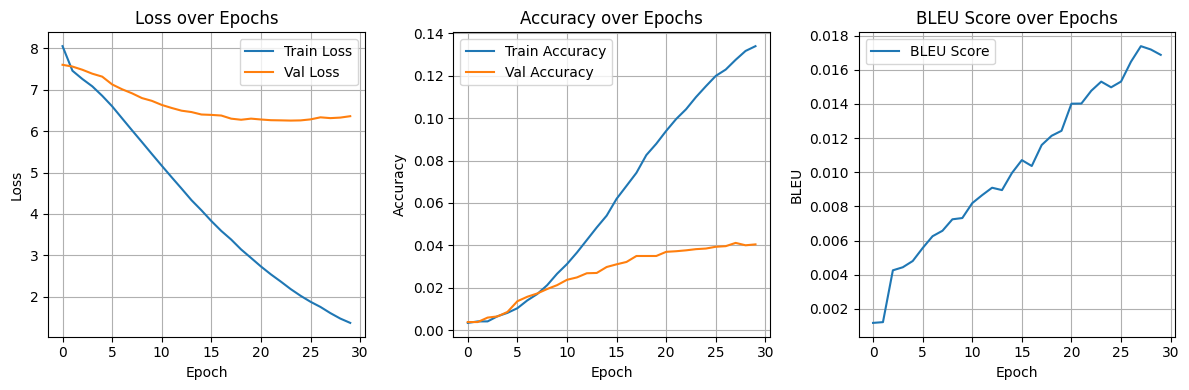

In [ ]:
plt.figure(figsize=(12, 4))

# ---- Plot 1: Training & Validation Loss ----
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# ---- Plot 2: Training & Validation Accuracy ----
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# ---- Plot 3: BLEU Score ----
plt.subplot(1, 3, 3)
plt.plot(bleu_scores, label='BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('BLEU')
plt.title('BLEU Score over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Training Curve Interpretation

The plots above represent the training dynamics of the Vision-Language Model over 30 epochs:

#### Loss Trends:
- **Training Loss** steadily decreases from ~8 to ~1.3, showing consistent learning.
- **Validation Loss** decreases initially and stabilizes after epoch 20, indicating the model is approaching its generalization capacity.
- A slight increase after epoch 25 suggests minor **overfitting**, which could be mitigated by early stopping or dropout tuning.

#### Accuracy Trends:
- **Training Accuracy** grows rapidly, reaching ~13.4%.
- **Validation Accuracy** improves slower and plateaus around ~4%, suggesting a **generalization gap**.
- This gap can likely be improved with:
  - Data augmentation
  - A larger validation set
  - Regularization methods

#### BLEU Score Trends:
- BLEU Score steadily improves from near-zero to ~0.017 across 30 epochs.
- While absolute values are low (due to strict n-gram matching), the **upward trend** confirms the model is improving in generating semantically and syntactically closer titles over time.

### Overall Takeaway:
- The model shows **consistent learning and improving text generation quality**.
- The BLEU score curve aligns with qualitative gains in prediction quality.
- For future work, exploring beam search, attention visualization, and richer text embeddings (e.g., subword units) could enhance performance.




---

## 4. Evaluation Results

This section presents the evaluation metrics and model outputs to assess performance.

### Evaluation Criteria:
- **Cosine Similarity**: Used to compare query vectors with database vectors.
- **BLEU Score**: Evaluates the textual similarity of predicted product titles.
- **Top-K Accuracy**: Checks whether the ground truth appears in top-K recommendations.

### Sample Outputs:
We show a few sample query inputs with their top recommended outputs based on multimodal similarity.

---


### Evaluation on the Test Set
This code block performs an intermediate operation in our pipeline. Please refer to inline comments for details.

In [ ]:
model.eval()  # Set model to evaluation mode

test_loss, test_total, test_correct = 0, 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, captions in test_loader:
        images, captions = images.to(device), captions.to(device)

        # Generate target mask for autoregressive decoding
        tgt_mask = generate_square_subsequent_mask(captions.size(1))

        # Forward pass through the model
        logits = model(images, captions, tgt_mask=tgt_mask)

        # Compute loss (excluding <PAD> tokens)
        loss = loss_fn(logits[:, :-1, :], captions[:, 1:])
        test_loss += loss.item()

        # Compute accuracy
        preds = logits[:, :-1, :].argmax(dim=-1)
        test_correct += (preds == captions[:, 1:]).sum().item()
        test_total += captions[:, 1:].numel()

# Report test performance
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_correct/test_total:.4f}")

Test Loss: 6.0424, Test Accuracy: 0.0475


### Utility: Extract Product Embeddings

This function allows you to extract a compact product embedding from:

- Image-only (`mode="image"`)
- Text-only (`mode="text"`)
- Fused (average of both, `mode="both"`)

---

#### Function: `get_product_embedding(...)`

**Inputs:**
- `model` – Trained `VisionLanguageModel`
- `image_tensor` – Single image tensor of shape (C, H, W)
- `title_tensor` – Tokenized title tensor of shape (T,)
- `mode` – Either `"image"`, `"text"`, or `"both"`

**Returns:**
- A single embedding vector of shape `(D,)`, which can be used for similarity comparison, clustering, or retrieval tasks.

Note: Uses mean pooling over patches or token embeddings to form the final representation.


In [ ]:
# -------------------------------------------------------------
# Utility Function: Extract Product Embedding from Text/Image
# -------------------------------------------------------------
def get_product_embedding(model, image_tensor, title_tensor, mode="text"):
    """
    Extracts a product embedding from either the image, text, or a fusion of both.

    Parameters:
        model        : Trained VisionLanguageModel
        image_tensor : Input image tensor (C x H x W)
        title_tensor : Tokenized title tensor (T,)
        mode         : "text", "image", or "both" to control the type of embedding

    Returns:
        Tensor of shape (D,) representing the embedding
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        # Forward pass through the visual encoder
        visual = model.vision_encoder(image_tensor.unsqueeze(0))  # (1, N_patches, D)

        # Embed the tokenized title using the decoder’s embedding layer
        text = model.decoder.embedding(title_tensor.unsqueeze(0))  # (1, T, D)

        # Compute mean-pooled embeddings
        visual_avg = visual.mean(dim=1)  # (1, D)
        text_avg = text.mean(dim=1)      # (1, D)

        # Return the appropriate embedding based on the selected mode
        if mode == "text":
            return text_avg.squeeze(0)  # (D,)
        elif mode == "image":
            return visual_avg.squeeze(0)  # (D,)
        else:
            return ((visual_avg + text_avg) / 2).squeeze(0)  # (D,)

In [ ]:
# ----------------------------------------------------------
# Preprocess a Single Product Entry (Image + Title Tokens)
# ----------------------------------------------------------


# Define preprocessing transform for input image
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to match training dimensions
    transforms.ToTensor()           # Convert to tensor format
])

def preprocess_input(asin_entry, tokenizer, max_len=64):
    """
    Prepares image and tokenized title for model inference.

    Parameters:
        asin_entry : A dictionary or row with keys 'image_name' and 'title'
        tokenizer  : Fitted tokenizer object
        max_len    : Maximum token length for title

    Returns:
        image_tensor : Transformed image tensor (C x H x W)
        token_ids    : Padded token ID tensor (T,)
    """
    # Construct full image path and load image
    img_path = os.path.join(
        "/content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All",
        asin_entry['image_name']
    )
    image = Image.open(img_path).convert("RGB")
    image = transform(image)

    # Tokenize the title
    title = asin_entry['title']
    token_ids = torch.tensor(tokenizer.encode(title, max_len=max_len), dtype=torch.long)

    return image, token_ids

### Inference
This code block performs an intermediate operation in our pipeline. Please refer to inline comments for details.

In [ ]:
# --------------------------------------------------------------
# Generate and Store Product Embeddings for the Entire Dataset
# --------------------------------------------------------------
product_embeddings = {}

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Iterate through each product entry in the DataFrame
for _, row in newDF.iterrows():
    # Preprocess image and title to obtain model-ready tensors
    img_tensor, title_tensor = preprocess_input(row, tokenizer)

    # Move inputs to the computation device (CPU or GPU)
    img_tensor = img_tensor.to(device)
    title_tensor = title_tensor.to(device)

    # Generate embedding (can be text, image, or hybrid)
    emb = get_product_embedding(model, img_tensor, title_tensor)

    # Store embedding keyed by the product's ASIN
    product_embeddings[row['asin']] = emb.to(device)

print(f"Populated product_embeddings for {len(product_embeddings)} items, all on device: {device}")

Populated product_embeddings for 1250 items, all on device: cuda


In [ ]:
# --------------------------------------------------------------
# Product Recommendation Function Based on Textual Similarity
# --------------------------------------------------------------

def recommend_similar_products(image_tensor, title_tensor, title_text, top_k=5):
    """
    Given a product image and title, recommend top-k similar products
    based on cosine similarity of embeddings and token overlap.

    Parameters:
    - image_tensor: Tensor representation of product image
    - title_tensor: Tokenized representation of product title
    - title_text: Original title string (used for word overlap computation)
    - top_k: Number of top recommendations to return

    Returns:
    - List of (ASIN, similarity score) tuples for the top-k matches
    """
    # Generate embedding for the query product (using text mode)
    query_emb = get_product_embedding(model, image_tensor, title_tensor, mode="text")

    # Extract individual words from the title for overlap boosting
    query_tokens = set(title_text.lower().split())
    similarities = []

    # Compare query with every stored product embedding
    for asin, emb in product_embeddings.items():
        # Compute cosine similarity between query and candidate embeddings
        sim = cosine_similarity(query_emb.unsqueeze(0), emb.unsqueeze(0)).item()

        # Retrieve the candidate product title from dataset
        product_title_row = newDF[newDF['asin'] == asin]['title']
        if not product_title_row.empty:
            product_tokens = set(product_title_row.iloc[0].lower().split())
            # Slightly boost similarity based on token overlap
            overlap = len(query_tokens.intersection(product_tokens))
            sim += 0.01 * overlap

        similarities.append((asin, sim))

    # Sort by similarity and return top-k results
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

In [ ]:
# --------------------------------------------------------------
# Hybrid Recommendation Function
# --------------------------------------------------------------
# Uses both visual and textual features from a given image and title
# to retrieve the top-k most similar products based on cosine similarity
# and token overlap.
# --------------------------------------------------------------

def hybrid_recommendation(image_path, title_text, top_k=5):
    """
    Computes hybrid recommendations for a given product image and title.

    Parameters:
    - image_path: Path to the input image file
    - title_text: Product title (string) corresponding to the image
    - top_k: Number of top similar products to return

    Returns:
    - List of (ASIN, similarity score) tuples for top-k similar products
    """
    # Load and preprocess the input image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)  # Apply resizing and normalization
    image = image.to(device)  # Move image to the appropriate device

    # Tokenize the title text and move to device
    title_tensor = torch.tensor(
        tokenizer.encode(title_text, max_len=64),
        dtype=torch.long
    ).to(device)

    # Generate top-k recommendations using text-based similarity
    similar_asins = recommend_similar_products(
        image_tensor=image,
        title_tensor=title_tensor,
        title_text=title_text,
        top_k=top_k
    )

    # Optional: Extract ASIN from image filename for reference
    # (Assumes filename structure starts with ASIN)
    asin_key = os.path.basename(image_path).split('_')[0].split('.')[0]

    return similar_asins

In [ ]:
# --------------------------------------------------------------
# Function to Display Images of Recommended Products
# --------------------------------------------------------------
# Inputs:
# - similar_asins: List of tuples (asin, similarity score)
# --------------------------------------------------------------
# Displays images in a row with ASINs as titles.
# Handles missing images gracefully and logs issues.
# --------------------------------------------------------------

image_folder_path = '/content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All'

def display_recommendations(similar_asins):
    def show_images(asins, title):
        found = False
        plt.figure(figsize=(15, 3))

        for i, asin in enumerate(asins):
            row = newDF[newDF['asin'] == asin]
            if row.empty:
                print(f"ASIN {asin} not found in dataframe.")
                continue

            image_name = row['image_name'].iloc[0]
            img_path = os.path.join(image_folder_path, image_name)

            # Check if image exists before attempting to display
            if os.path.exists(img_path):
                print(f"Found: {img_path}")
                found = True
                img = Image.open(img_path)

                plt.subplot(1, len(asins), i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(asin)
            else:
                print(f"Image not found for ASIN: {asin} -> {img_path}")

        if found:
            plt.suptitle(title)
            plt.show()
        else:
            print(f"No displayable images found for {title}.")

    # Extract ASINs from (asin, score) tuples
    asin_list = [a[0] for a in similar_asins]
    show_images(asin_list, "System Recommended (Similar Products)")

In [ ]:
newDF[newDF['asin'] == 'B00IB1D0IO']

,asin,title,image_name
587,B00IB1D0IO,"Barilla Pasta, Rotini, 16 Ounce",75_B00IB1D0IO_0.jpg


System Recommended (Similar Products): [('B00IB1D0IO', 1.05), ('B00X7ZWZL2', 1.0397225403785706), ('B00X7ZY82Q', 1.0397037649154663), ('B00X7ZXBTM', 1.0396853470802307), ('B00X7ZWKZ8', 1.039677300453186)]
Looking for: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/75_B00IB1D0IO_0.jpg
✅ Found: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/75_B00IB1D0IO_0.jpg
Looking for: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/540_B00X7ZWZL2_3.jpg
✅ Found: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/540_B00X7ZWZL2_3.jpg
Looking for: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/539_B00X7ZY82Q_2.jpg
✅ Found: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/539_B00X7ZY82Q_2.jpg
Looking for: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/542_B00X7ZXBTM_2.jpg
✅ Found: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/542_B00X7ZXBTM_2.jpg
Looking for: /content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/A

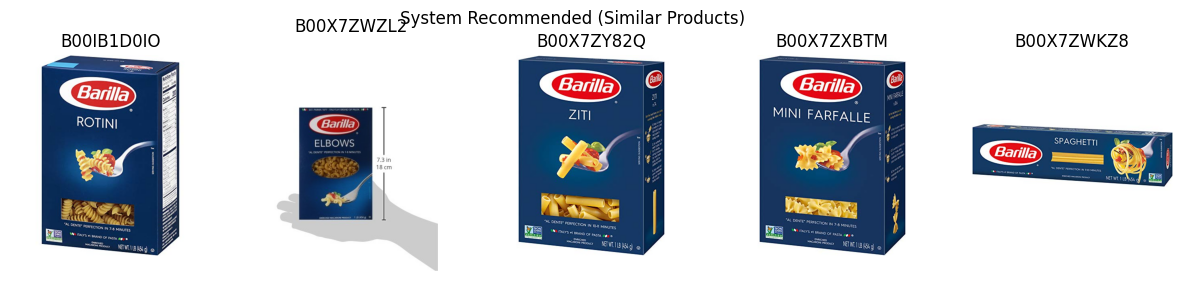

In [ ]:
uploaded_image_path = '/content/drive/MyDrive/CSC 528 Prime_Pantry_VRS/Sorted/All/75_B00IB1D0IO_0.jpg'
title_text = "Barilla Pasta, Rotini, 16 Ounce"

similar_asins = hybrid_recommendation(uploaded_image_path, title_text, top_k=5)
print("System Recommended (Similar Products):", similar_asins)

display_recommendations(similar_asins)